# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [53]:
import warnings
warnings.filterwarnings('ignore')

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Problem Definition

In this project, we are going to explore the Starbucks simulated marketing promotions data and customers reponses toward the promotion. We will look at two promitions, BOGO (Buy one and get one free) and discount. 

We are going to build supervised Machine Learning model to predict which type of customers likes those offers. We will use binary classifier algorithm to to that.


# Loading Data and Python packages

In [3]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
#% matplotlib inline

#: import additional library
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score


import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Explorer Data

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [9]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [10]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

# Data Prep

## cleaning portfolio dataset

In [11]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [12]:
#: create dummy columsn for 'offer_type'
portfolio_clean = portfolio.join(pd.get_dummies(portfolio['offer_type']))
#: keep offer_type column for plotting purpose
#portfolio_clean.drop(columns=['offer_type'], inplace=True)
portfolio_clean

,reward,channels,difficulty,duration,offer_type,id,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,0


In [13]:
#:Seperate out 'channels' column
portfolio_clean['email'] = portfolio_clean['channels'].astype(str).str.contains('email').astype(int) 
portfolio_clean['mobile'] = portfolio_clean['channels'].astype(str).str.contains('mobile').astype(int) 
portfolio_clean['social'] = portfolio_clean['channels'].astype(str).str.contains('social').astype(int) 
portfolio_clean['web'] = portfolio_clean['channels'].astype(str).str.contains('web').astype(int) 
portfolio_clean.drop(columns=['channels'], inplace=True)
portfolio_clean

,reward,difficulty,duration,offer_type,id,bogo,discount,informational,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


## Cleaning transcript dataset

In [14]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
pd.get_dummies(transcript['event'])

,offer completed,offer received,offer viewed,transaction
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
306529,0,0,0,1
306530,0,0,0,1
306531,0,0,0,1
306532,0,0,0,1


In [16]:
#: create transscript_clean Dataframe to store cleaned data
transcript_clean = transcript.join(pd.get_dummies(transcript['event']))
#: drop the 'event' column
transcript_clean.drop(columns=['event'], inplace=True)
transcript_clean

,person,value,time,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,{'amount': 1.5899999999999999},714,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,{'amount': 9.53},714,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,{'amount': 3.61},714,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,{'amount': 3.5300000000000002},714,0,0,0,1


In [17]:
#: convert the dictionaries in the value column into new columns
df_value = transcript_clean['value'].apply(pd.Series)


In [18]:
transcript_clean = pd.concat([transcript_clean, df_value], axis=1)
transcript_clean.drop(columns=['value'], inplace=True)
transcript_clean

,person,time,offer completed,offer received,offer viewed,transaction,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,0,0,0,1,NaN,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,0,0,0,1,NaN,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,714,0,0,0,1,NaN,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,0,0,0,1,NaN,3.53,NaN,NaN


In [19]:
#: we need to make sure that do duplicate in offer id and offer_id columsn
transcript_clean[~transcript_clean['offer id'].isnull() & ~transcript_clean['offer_id'].isnull() ]

,person,time,offer completed,offer received,offer viewed,transaction,offer id,amount,offer_id,reward


In [20]:
#: merge offer_id and offer id columns into one
transcript_clean['offer_id'].fillna(transcript_clean['offer id'], inplace=True)


In [21]:
#: drop offer id column
transcript_clean.drop(columns = ['offer id'], inplace=True)
transcript_clean

,person,time,offer completed,offer received,offer viewed,transaction,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,0,0,0,1,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,0,0,0,1,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,714,0,0,0,1,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,0,0,0,1,3.53,NaN,NaN


In [22]:
#: Filter out transcript without offer id 
#: Remove not related columsn for offer: transacion, amount 
transcript_clean = transcript_clean[~transcript_clean['offer_id'].isnull()].drop(columns=['transaction', 'amount','reward'])
transcript_clean

,person,time,offer completed,offer received,offer viewed,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,714,1,0,0,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,714,1,0,0,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,714,1,0,0,fafdcd668e3743c1bb461111dcafc2a4


## Merge all datasets

### Merge transcript and portfolio datasets

In [23]:
#: merge transcript and portfolio 
transcript_portfolio = pd.merge(transcript_clean, portfolio_clean, how='left', left_on='offer_id', right_on='id')
transcript_portfolio.drop(columns=['id'], inplace=True)
transcript_portfolio


,person,time,offer completed,offer received,offer viewed,offer_id,reward,difficulty,duration,offer_type,bogo,discount,informational,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,0,0,1,1,0,1
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,0,1,0,1,0,0,1
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,2906b810c7d4411798c6938adc9daaa5,2,10,7,discount,0,1,0,1,1,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,0,1,0,1,1,1,1
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167576,a6f84f4e976f44508c358cc9aba6d2b3,714,1,0,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,0,1,0,1,1,1,1
167577,b895c57e8cd047a8872ce02aa54759d6,714,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,0,1,0,1,1,1,1
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,0,1,0,1,0,0,1
167579,8431c16f8e1d440880db371a68f82dd0,714,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,0,1,0,1,1,1,1


### Merge profile dataset

In [24]:
transcript_portfolio_profile = pd.merge(transcript_portfolio, profile, how='left', left_on='person', right_on='id')
transcript_portfolio_profile.drop(columns=['id'], inplace=True) #: duplicated column as person
#: drop na
transcript_portfolio_profile.dropna(inplace=True)
transcript_portfolio_profile


,person,time,offer completed,offer received,offer viewed,offer_id,reward,difficulty,duration,offer_type,...,discount,informational,email,mobile,social,web,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,...,0,0,1,1,0,1,F,75,20170509,100000.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,2906b810c7d4411798c6938adc9daaa5,2,10,7,discount,...,1,0,1,1,0,1,M,68,20180426,70000.0
5,389bc3fa690240e798340f5a15918d5c,0,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,...,0,0,1,1,1,1,M,65,20180209,53000.0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,...,0,1,1,1,0,1,M,58,20171111,51000.0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,...,1,0,1,0,0,1,F,61,20170911,57000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167574,84fb57a7fe8045a8bf6236738ee73a0f,714,0,0,1,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,...,0,1,1,1,1,0,F,64,20170615,113000.0
167575,abc4359eb34e4e2ca2349da2ddf771b6,714,0,0,1,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,...,0,1,1,1,0,1,M,51,20140804,68000.0
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,...,1,0,1,0,0,1,F,60,20170908,64000.0
167579,8431c16f8e1d440880db371a68f82dd0,714,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,...,1,0,1,1,1,1,M,39,20180627,39000.0


### Prepare Label Data

In [25]:
group_person_offer = transcript_portfolio_profile.groupby(['person', 'offer_id'],as_index=False).sum()[['person', 'offer_id', 'offer completed', 'offer received', 'offer viewed']]
#: create extra columns to compute viewed and completed count
group_person_offer['completed-viewed'] = group_person_offer['offer completed'].astype(int) - group_person_offer['offer viewed'].astype(int) 
group_person_offer['viewed and completed'] = group_person_offer['completed-viewed'].map(lambda x: 1 if x==0 else 0 )  
#: to cover multiple viewed and completed offers
group_person_offer['viewed and completed'] = group_person_offer['viewed and completed'].astype(int) * group_person_offer['offer completed'].astype(int) 
group_person_offer.drop(columns=['completed-viewed'], inplace=True)
group_person_offer

#: merge with portfolio_clean to get the offer_type column
group_person_offer = pd.merge(group_person_offer, portfolio_clean[['id','offer_type']], how='left', left_on='offer_id', right_on='id')
group_person_offer.drop(columns=['id'], inplace=True)
group_person_offer


,person,offer_id,offer completed,offer received,offer viewed,viewed and completed,offer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,discount
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,informational
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,informational
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount
...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,2,bogo
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,1,discount
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,3,discount
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,bogo


In [26]:
#: viewed and completed offer
viewed_completed_offers = group_person_offer.groupby(['offer_type'])['offer completed','offer received','offer viewed','viewed and completed'].sum()
viewed_completed_offers['viewed and completed rate'] = viewed_completed_offers['viewed and completed']/viewed_completed_offers['offer received']
viewed_completed_offers['completed rate'] = viewed_completed_offers['offer completed']/viewed_completed_offers['offer received']
viewed_completed_offers['completed without viewing rate'] = viewed_completed_offers['completed rate'] - viewed_completed_offers['viewed and completed rate'] 
viewed_completed_offers


,offer completed,offer received,offer viewed,viewed and completed,viewed and completed rate,completed rate,completed without viewing rate
offer_type,,,,,,,
bogo,15258.0,26537.0,22039.0,11994,0.451973,0.574971,0.122998
discount,17186.0,26664.0,18461.0,12824,0.480948,0.644539,0.163591
informational,0.0,13300.0,9360.0,0,0.000000,0.000000,0.000000


/Users/jaesong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


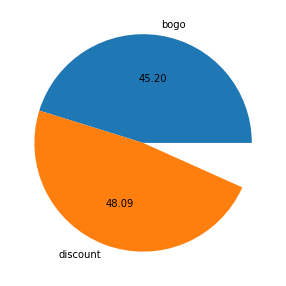

In [27]:
plt.figure(figsize=(8,5))
plt.pie(viewed_completed_offers.reset_index()[['viewed and completed rate']].iloc[:2], autopct='%.2f',labels=['bogo','discount'])
plt.show()

### Note about offers
- Customers complted more of discount type offers than bogo type.
- Bogo has 12% and Discount has 16% of customers who completed offers without viewing.

## Merge group_person_offer with profile to prepare data for ML models

In [28]:
#: merge all the data set to have all of features 
combined_data = pd.merge(group_person_offer, profile, how='left', left_on = 'person', right_on='id')
combined_data = pd.merge(combined_data, portfolio_clean, how='left', left_on = 'offer_id', right_on='id')
combined_data.drop(columns=['id_x', 'id_y','offer_type_y'], inplace=True)
combined_data.rename(columns={'offer_type_x':'offer_type'}, inplace=True)
combined_data.info()
combined_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 55221
Data columns (total 21 columns):
person                  55222 non-null object
offer_id                55222 non-null object
offer completed         55222 non-null uint8
offer received          55222 non-null uint8
offer viewed            55222 non-null uint8
viewed and completed    55222 non-null int64
offer_type              55222 non-null object
gender                  55222 non-null object
age                     55222 non-null int64
became_member_on        55222 non-null int64
income                  55222 non-null float64
reward                  55222 non-null int64
difficulty              55222 non-null int64
duration                55222 non-null int64
bogo                    55222 non-null uint8
discount                55222 non-null uint8
informational           55222 non-null uint8
email                   55222 non-null int64
mobile                  55222 non-null int64
social                  55222 

,person,offer_id,offer completed,offer received,offer viewed,viewed and completed,offer_type,gender,age,became_member_on,...,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,discount,M,33,20170421,...,2,10,7,0,1,0,1,1,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,informational,M,33,20170421,...,0,0,4,0,0,1,1,1,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,informational,M,33,20170421,...,0,0,3,0,0,1,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo,M,33,20170421,...,5,5,5,1,0,0,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount,M,33,20170421,...,2,10,10,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,2,bogo,M,34,20170123,...,5,5,5,1,0,0,1,1,1,1
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,1,discount,F,45,20161125,...,5,20,10,0,1,0,1,0,0,1
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,3,discount,F,45,20161125,...,2,10,7,0,1,0,1,1,0,1
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,bogo,F,45,20161125,...,5,5,7,1,0,0,1,1,0,1


# Data Prep for Bogo dataset

In [29]:
#: separate BOGO and Discount data
combined_data4Bogo = combined_data[combined_data['bogo']==1]
combined_data4Bogo.drop(columns=['bogo', 'discount', 'informational', 'person', 'offer_id', 'offer completed', 'offer received', 'offer viewed', 'offer_type'], inplace=True)
combined_data4Bogo


/Users/jaesong/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,viewed and completed,gender,age,became_member_on,income,reward,difficulty,duration,email,mobile,social,web
3,1,M,33,20170421,72000.0,5,5,5,1,1,1,1
9,1,O,40,20180109,57000.0,5,5,7,1,1,0,1
10,1,F,59,20160304,90000.0,10,10,5,1,1,1,1
12,0,F,59,20160304,90000.0,10,10,7,1,1,1,0
16,1,F,24,20161111,60000.0,5,5,7,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
55210,0,M,71,20171031,73000.0,10,10,7,1,1,1,0
55213,0,M,71,20180218,56000.0,10,10,5,1,1,1,1
55216,1,M,34,20170123,34000.0,5,5,7,1,1,0,1
55217,2,M,34,20170123,34000.0,5,5,5,1,1,1,1


### Create the label data for ML models

In [30]:
#: change the label (y variable) to 1 or 0
combined_data4Bogo['viewed and completed'] = np.where(combined_data4Bogo['viewed and completed']>0, 1,0)



/Users/jaesong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Feature Engineering for Bogo dataset

### age categorical data and ordinal encoding

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb81523ed90>]],
      dtype=object)

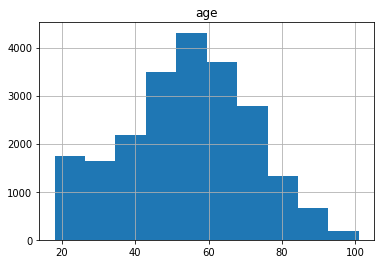

In [31]:
combined_data4Bogo[['age']].hist()

/Users/jaesong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


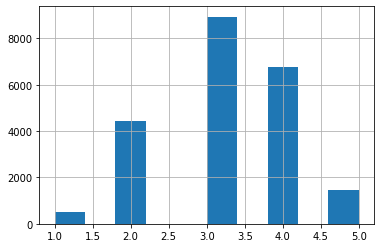

In [32]:
combined_data4Bogo['age_cat'] = pd.cut(combined_data4Bogo['age'],
                                               bins=[0,20,40,60,80,np.inf],
                                               labels = [1,2,3,4,5])

#: 'teens','20-30','40-50','60-80', '80+'
combined_data4Bogo['age_cat'].hist()

#: remove the age column
combined_data4Bogo.drop(columns=['age'], inplace=True)

### Income categorical data and ordinal encoding

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8151f3bd0>]],
      dtype=object)

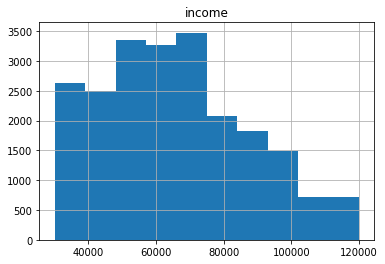

In [33]:
combined_data4Bogo[['income']].hist()

/Users/jaesong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


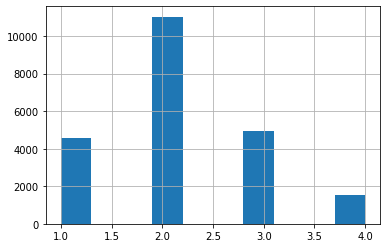

In [34]:
combined_data4Bogo['income_cat'] = pd.cut(combined_data4Bogo['income'],
                                               bins=[0,45000,75000,100000,np.inf],
                                               labels = [1,2,3,4])

#: 'less45k','45k-75k','75k-100','100k+'
combined_data4Bogo['income_cat'].hist()

#: remove the incoe column
combined_data4Bogo.drop(columns=['income'], inplace=True)

### Gender categorical data and one-hot encoding

In [35]:
combined_data4Bogo['gender'].value_counts()

M    12662
F     9097
O      303
Name: gender, dtype: int64

In [36]:
#: filter out the rows with gender with O because the size of O is too small
combined_data4Bogo = combined_data4Bogo[combined_data4Bogo['gender'] != 'O'] 

In [37]:
combined_data4Bogo['gender'].value_counts()

M    12662
F     9097
Name: gender, dtype: int64

In [38]:
#: use one hot encoding for more categorical data
gender_data = pd.get_dummies(combined_data4Bogo['gender'], prefix='gender')
gender_data


,gender_F,gender_M
3,0,1
10,1,0
12,1,0
16,1,0
17,1,0
...,...,...
55210,0,1
55213,0,1
55216,0,1
55217,0,1


In [39]:
#: remove the gender column
combined_data4Bogo.drop(columns=['gender'], inplace=True)

combined_data4Bogo = pd.concat([combined_data4Bogo, gender_data],axis=1)
combined_data4Bogo

,viewed and completed,became_member_on,reward,difficulty,duration,email,mobile,social,web,age_cat,income_cat,gender_F,gender_M
3,1,20170421,5,5,5,1,1,1,1,2,2,0,1
10,1,20160304,10,10,5,1,1,1,1,3,3,1,0
12,0,20160304,10,10,7,1,1,1,0,3,3,1,0
16,1,20161111,5,5,7,1,1,0,1,2,2,1,0
17,1,20161111,5,5,5,1,1,1,1,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55210,0,20171031,10,10,7,1,1,1,0,4,2,0,1
55213,0,20180218,10,10,5,1,1,1,1,4,2,0,1
55216,1,20170123,5,5,7,1,1,0,1,2,1,0,1
55217,1,20170123,5,5,5,1,1,1,1,2,1,0,1


### Other categorical data

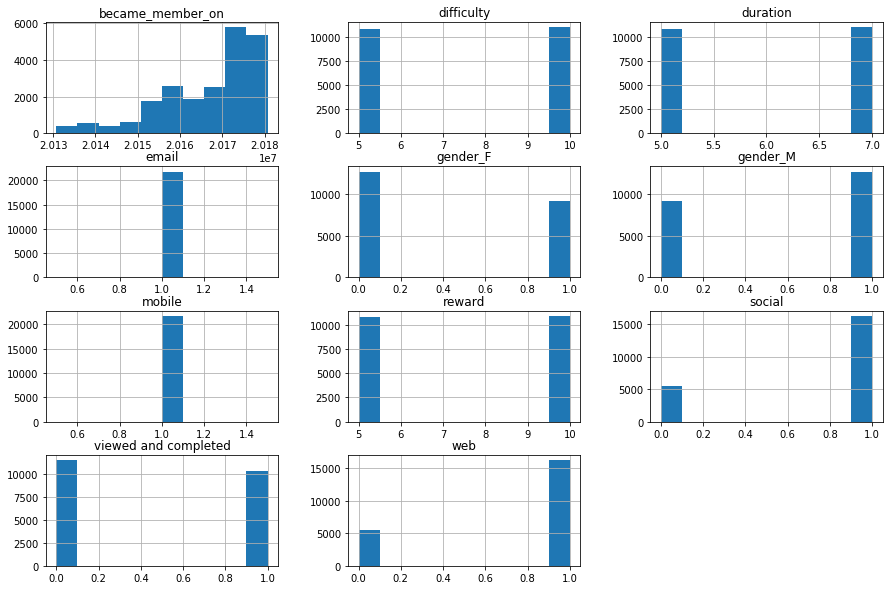

In [40]:
combined_data4Bogo.hist(figsize=(15,10))
plt.show()


In [41]:
#: remove columns that won't add much values
combined_data4Bogo.drop(columns=['email','mobile','became_member_on'], inplace=True)


### One-Hot encoding for other categorical data

In [42]:
#: other categorical data
duration_data = pd.get_dummies(combined_data4Bogo['duration'], prefix='duration')
difficulty_data = pd.get_dummies(combined_data4Bogo['difficulty'], prefix='difficulty')
reward_data = pd.get_dummies(combined_data4Bogo['reward'], prefix='reward')
social_data = pd.get_dummies(combined_data4Bogo['social'], prefix='social')

combined_data4Bogo = pd.concat([combined_data4Bogo, duration_data],axis='columns')
combined_data4Bogo = pd.concat([combined_data4Bogo, difficulty_data],axis='columns')
combined_data4Bogo = pd.concat([combined_data4Bogo, reward_data],axis='columns')
combined_data4Bogo = pd.concat([combined_data4Bogo, social_data],axis='columns')

combined_data4Bogo.drop(['duration','difficulty','reward','social'], axis='columns', inplace=True)
combined_data4Bogo.head()

,viewed and completed,web,age_cat,income_cat,gender_F,gender_M,duration_5,duration_7,difficulty_5,difficulty_10,reward_5,reward_10,social_0,social_1
3,1,1,2,2,0,1,1,0,1,0,1,0,0,1
10,1,1,3,3,1,0,1,0,0,1,0,1,0,1
12,0,0,3,3,1,0,0,1,0,1,0,1,0,1
16,1,1,2,2,1,0,0,1,1,0,1,0,1,0
17,1,1,2,2,1,0,1,0,1,0,1,0,0,1


# Evaluate Models for Bogo dataset

## Split Train and Test data using Stratified 

In [43]:
train, test = train_test_split(combined_data4Bogo, test_size=0.2, random_state=0, 
                               stratify=combined_data4Bogo[['income_cat', 'age_cat','gender_F','gender_M']])

In [44]:
test["income_cat"].value_counts() / len(test)

2    0.500230
3    0.223116
1    0.207491
4    0.069164
Name: income_cat, dtype: float64

In [45]:
combined_data4Bogo["income_cat"].value_counts() / len(combined_data4Bogo)

2    0.499885
3    0.223034
1    0.207638
4    0.069443
Name: income_cat, dtype: float64

In [46]:
#: one-hot encoding for age_cat and income_cat in training and test data once stratified technique is used
age_cat_train = pd.get_dummies(train['age_cat'], prefix='age_cat')
age_cat_test = pd.get_dummies(test['age_cat'], prefix='age_cat')

income_cat_train = pd.get_dummies(train['income_cat'], prefix='income_cat')
income_cat_test = pd.get_dummies(test['income_cat'], prefix='income_cat')


#: remove the age_cat and income_cat columns
train.drop(columns=['age_cat','income_cat' ], inplace=True)
test.drop(columns=['age_cat','income_cat' ], inplace=True)


train = pd.concat([train, age_cat_train,income_cat_train],axis=1)
test = pd.concat([test, age_cat_test,income_cat_test],axis=1)



/Users/jaesong/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17407 entries, 35270 to 35016
Data columns (total 21 columns):
viewed and completed    17407 non-null int64
web                     17407 non-null int64
gender_F                17407 non-null uint8
gender_M                17407 non-null uint8
duration_5              17407 non-null uint8
duration_7              17407 non-null uint8
difficulty_5            17407 non-null uint8
difficulty_10           17407 non-null uint8
reward_5                17407 non-null uint8
reward_10               17407 non-null uint8
social_0                17407 non-null uint8
social_1                17407 non-null uint8
age_cat_1               17407 non-null uint8
age_cat_2               17407 non-null uint8
age_cat_3               17407 non-null uint8
age_cat_4               17407 non-null uint8
age_cat_5               17407 non-null uint8
income_cat_1            17407 non-null uint8
income_cat_2            17407 non-null uint8
income_cat_3            17407 no

In [48]:
y_train = train.iloc[:,0]
y_test = test.iloc[:,0]

X_train = train.iloc[:,1:]
X_test = test.iloc[:,1:]



### Distribution of training label data

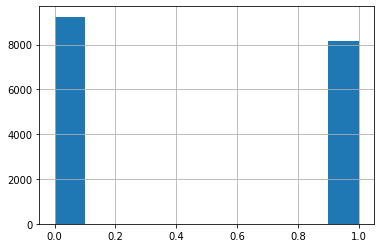

In [49]:
y_train.hist()

In [50]:
models = []
#: Decision Tree model
models.append(('CART', DecisionTreeClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))


## K-fold cross validation to pick classifier models

In this step, we will evaluate different classification models using K-fold cross validation.
We will evaluate algorithms using the accuracy metric.


In [54]:
num_folds = 4
seed = 7
scoring = 'accuracy'

results = []
names = []
for name, model in models:
    #kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

CART: 0.638021 (0.006344)
LR: 0.623427 (0.001539)
KNN: 0.571838 (0.010391)
AB: 0.622451 (0.001639)
GBM: 0.634401 (0.006262)
RF: 0.636010 (0.007710)
ET: 0.638021 (0.006344)


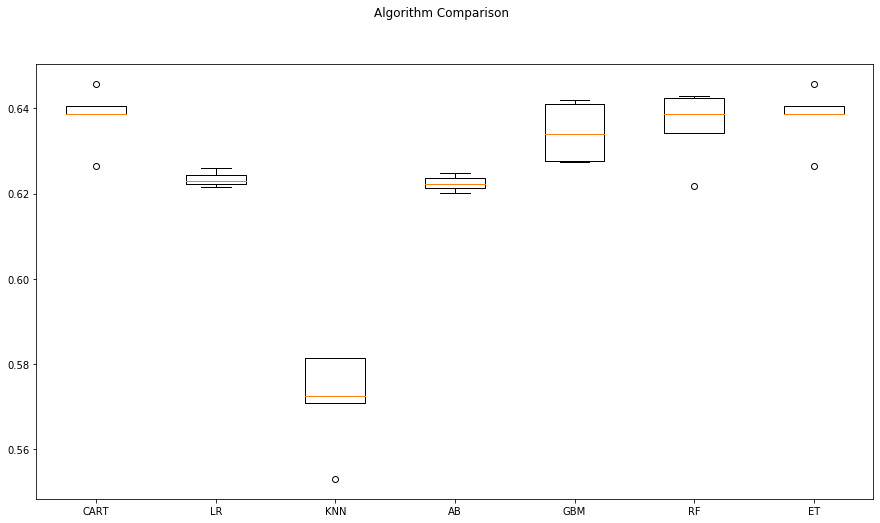

In [55]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

## Refinement

Let's use Grid Search to turn the hyperparameter to get the best hyperparameters to predict the test dataset

In [81]:
estimator = DecisionTreeClassifier()
estimator.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [75]:
estimator = DecisionTreeClassifier()

for param in estimator.get_params().keys():
    print(param)

class_weight
criterion
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_impurity_split
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
presort
random_state
splitter


In [76]:
# Grid Search for CART model

param_dict = {
    'criterion':['gini','entropy'],
    'max_depth': range(1,20),
    'min_samples_split': range(2,10),
    'min_samples_leaf': range(1,5)
}

grid = GridSearchCV(DecisionTreeClassifier(), 
                    param_grid=param_dict, 
                    cv = 10,
                    verbose =1,n_jobs=-1)

grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 10 folds for each of 1216 candidates, totalling 12160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1586 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 4086 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 7586 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12086 tasks      | elapsed:  1.8min


Best: 0.636813 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


[Parallel(n_jobs=-1)]: Done 12160 out of 12160 | elapsed:  1.8min finished


## Model evaluation and validation

In [77]:
grid_result.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [78]:
grid_result.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## Justification

In [80]:
grid_result.best_score_

0.6368127764692365

## Predict Test dataset

In [82]:
#: build the model with best hyperparameters chosen
model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=1, min_samples_split=2)
#: fit the model to the training data
model.fit(X_train, y_train)

#: make predictions on the test data
y_pred = model.predict(X_test)

#: Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.6438419117647058


## Feature Importance

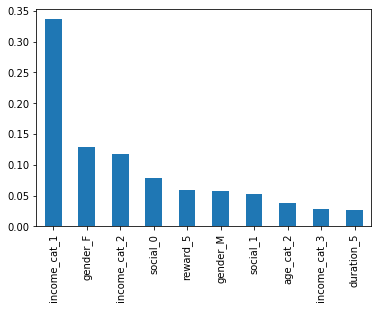

In [83]:
feature_importance = pd.Series(data=model.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False).head(10).plot(kind='bar')

# Data Prep for Discount dataset

In [84]:
#: discount
combined_data4Discount = combined_data[combined_data['discount']==1]
combined_data4Discount.drop(columns=['bogo', 'discount', 'informational', 'person', 'offer_id', 'offer completed', 'offer received', 'offer viewed', 'offer_type'], inplace=True)
combined_data4Discount

,viewed and completed,gender,age,became_member_on,income,reward,difficulty,duration,email,mobile,social,web
0,0,M,33,20170421,72000.0,2,10,7,1,1,0,1
4,1,M,33,20170421,72000.0,2,10,10,1,1,1,1
5,1,O,40,20180109,57000.0,5,20,10,1,0,0,1
6,1,O,40,20180109,57000.0,3,7,7,1,1,1,1
13,0,F,59,20160304,90000.0,2,10,10,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
55211,2,M,71,20171031,73000.0,2,10,10,1,1,1,1
55214,0,M,71,20180218,56000.0,2,10,10,1,1,1,1
55218,1,F,45,20161125,62000.0,5,20,10,1,0,0,1
55219,3,F,45,20161125,62000.0,2,10,7,1,1,0,1


In [85]:
#: change the label (y variable) to 1 or 0
combined_data4Discount['viewed and completed'] = np.where(combined_data4Discount['viewed and completed']>0, 1,0)


## Feature Engineering for Discount dataset

### age categorical data and ordinal encoding

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8145ad3d0>]],
      dtype=object)

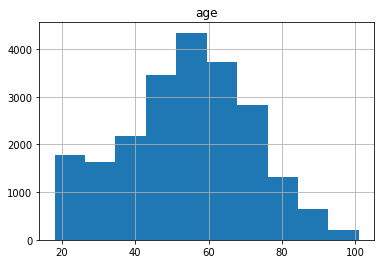

In [86]:
combined_data4Discount[['age']].hist()

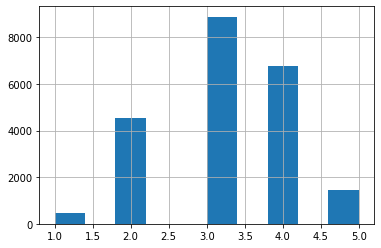

In [87]:
combined_data4Discount['age_cat'] = pd.cut(combined_data4Discount['age'],
                                               bins=[0,20,40,60,80,np.inf],
                                               labels = [1,2,3,4,5])

#: 'teens','20-30','40-50','60-80', '80+'
combined_data4Discount['age_cat'].hist()

#: remove the age column
combined_data4Discount.drop(columns=['age'], inplace=True)

### income categorical data and ordinal encoding

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb814569f50>]],
      dtype=object)

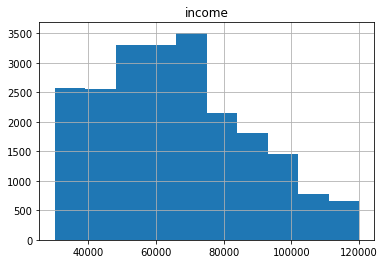

In [88]:
combined_data4Discount[['income']].hist()

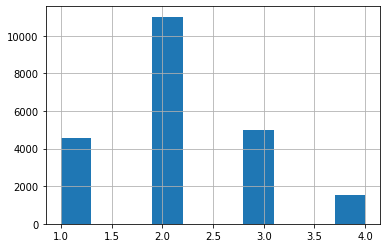

In [89]:
combined_data4Discount['income_cat'] = pd.cut(combined_data4Discount['income'],
                                               bins=[0,45000,75000,100000,np.inf],
                                               labels = [1,2,3,4])

#: 'less45k','45k-75k','75k-100','100k+'
combined_data4Discount['income_cat'].hist()

#: remove the incoe column
combined_data4Discount.drop(columns=['income'], inplace=True)

### gender categorical data and one-hot encoding

In [90]:
combined_data4Discount['gender'].value_counts()

M    12706
F     9110
O      303
Name: gender, dtype: int64

In [91]:
#: filter out the rows with gender with O because of so small portion
combined_data4Discount = combined_data4Discount[combined_data4Discount['gender'] != 'O'] 

In [92]:
combined_data4Discount['gender'].value_counts()

M    12706
F     9110
Name: gender, dtype: int64

In [93]:
#: use one hot encoding for more categorical data
gender_data_discount = pd.get_dummies(combined_data4Discount['gender'], prefix='gender')
gender_data_discount


,gender_F,gender_M
0,0,1
4,0,1
13,1,0
14,1,0
18,1,0
...,...,...
55211,0,1
55214,0,1
55218,1,0
55219,1,0


In [94]:
#: remove the gender column
combined_data4Discount.drop(columns=['gender'], inplace=True)

combined_data4Discount = pd.concat([combined_data4Discount, gender_data_discount],axis=1)
combined_data4Discount

,viewed and completed,became_member_on,reward,difficulty,duration,email,mobile,social,web,age_cat,income_cat,gender_F,gender_M
0,0,20170421,2,10,7,1,1,0,1,2,2,0,1
4,1,20170421,2,10,10,1,1,1,1,2,2,0,1
13,0,20160304,2,10,10,1,1,1,1,3,3,1,0
14,1,20161111,3,7,7,1,1,1,1,2,2,1,0
18,0,20170621,5,20,10,1,0,0,1,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55211,1,20171031,2,10,10,1,1,1,1,4,2,0,1
55214,0,20180218,2,10,10,1,1,1,1,4,2,0,1
55218,1,20161125,5,20,10,1,0,0,1,3,2,1,0
55219,1,20161125,2,10,7,1,1,0,1,3,2,1,0


### Other categorical data

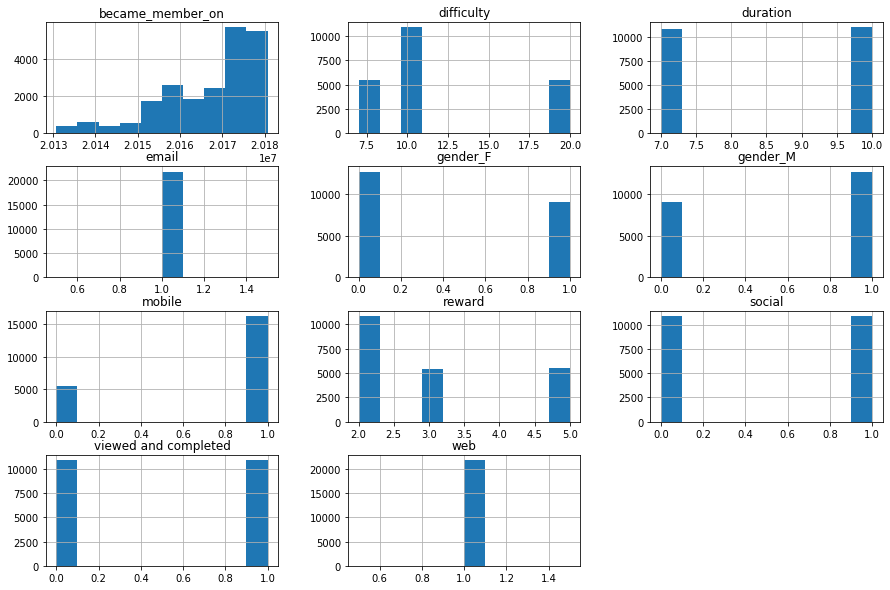

In [95]:
combined_data4Discount.hist(figsize=(15,10))
plt.show()


In [96]:
combined_data4Discount.drop(columns=['email','web','became_member_on'], inplace=True)


### One hot encoding for other categorical data

In [97]:
#: other categorical data
duration_data = pd.get_dummies(combined_data4Discount['duration'], prefix='duration')
difficulty_data = pd.get_dummies(combined_data4Discount['difficulty'], prefix='difficulty')
reward_data = pd.get_dummies(combined_data4Discount['reward'], prefix='reward')
social_data = pd.get_dummies(combined_data4Discount['social'], prefix='social')
mobile_data = pd.get_dummies(combined_data4Discount['mobile'], prefix='mobile')

combined_data4Discount = pd.concat([combined_data4Discount, duration_data],axis='columns')
combined_data4Discount = pd.concat([combined_data4Discount, difficulty_data],axis='columns')
combined_data4Discount = pd.concat([combined_data4Discount, reward_data],axis='columns')
combined_data4Discount = pd.concat([combined_data4Discount, social_data],axis='columns')
combined_data4Discount = pd.concat([combined_data4Discount, mobile_data],axis='columns')

combined_data4Discount.drop(['duration','difficulty','reward','social','mobile'], axis='columns', inplace=True)
combined_data4Discount.head()

,viewed and completed,age_cat,income_cat,gender_F,gender_M,duration_7,duration_10,difficulty_7,difficulty_10,difficulty_20,reward_2,reward_3,reward_5,social_0,social_1,mobile_0,mobile_1
0,0,2,2,0,1,1,0,0,1,0,1,0,0,1,0,0,1
4,1,2,2,0,1,0,1,0,1,0,1,0,0,0,1,0,1
13,0,3,3,1,0,0,1,0,1,0,1,0,0,0,1,0,1
14,1,2,2,1,0,1,0,1,0,0,0,1,0,0,1,0,1
18,0,2,2,1,0,0,1,0,0,1,0,0,1,1,0,1,0


# Evaluate Models for Discount dataset


## Split Train and Test data using Stratified 


In [98]:
train, test = train_test_split(combined_data4Discount, test_size=0.2, random_state=0, 
                               stratify=combined_data4Discount[['income_cat', 'age_cat','gender_F','gender_M']])

In [99]:
test["income_cat"].value_counts() / len(test)

2    0.497938
3    0.225710
1    0.207149
4    0.069203
Name: income_cat, dtype: float64

In [100]:
combined_data4Discount["income_cat"].value_counts() / len(combined_data4Discount)

2    0.498166
3    0.225614
1    0.207096
4    0.069124
Name: income_cat, dtype: float64

In [101]:
#: one-hot encoding for age_cat and income_cat in training and test data once stratified technique is used
age_cat_train = pd.get_dummies(train['age_cat'], prefix='age_cat')
age_cat_test = pd.get_dummies(test['age_cat'], prefix='age_cat')

income_cat_train = pd.get_dummies(train['income_cat'], prefix='income_cat')
income_cat_test = pd.get_dummies(test['income_cat'], prefix='income_cat')


#: remove the age_cat and income_cat columns
train.drop(columns=['age_cat','income_cat' ], inplace=True)
test.drop(columns=['age_cat','income_cat' ], inplace=True)


train = pd.concat([train, age_cat_train,income_cat_train],axis=1)
test = pd.concat([test, age_cat_test,income_cat_test],axis=1)



In [102]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 11)
y_train = train.iloc[:,0]
y_test = test.iloc[:,0]

X_train = train.iloc[:,1:]
X_test = test.iloc[:,1:]


In [103]:
models = []
#: Decision Tree model
models.append(('CART', DecisionTreeClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))


## K-fold cross validation to pick classifier models

In [104]:
num_folds = 4
seed = 7
scoring = 'accuracy'

results = []
names = []
for name, model in models:
    #kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

CART: 0.706050 (0.009674)
LR: 0.701809 (0.011352)
KNN: 0.672643 (0.013254)
AB: 0.702955 (0.010329)
GBM: 0.707138 (0.010657)
RF: 0.704961 (0.009944)
ET: 0.706050 (0.009674)


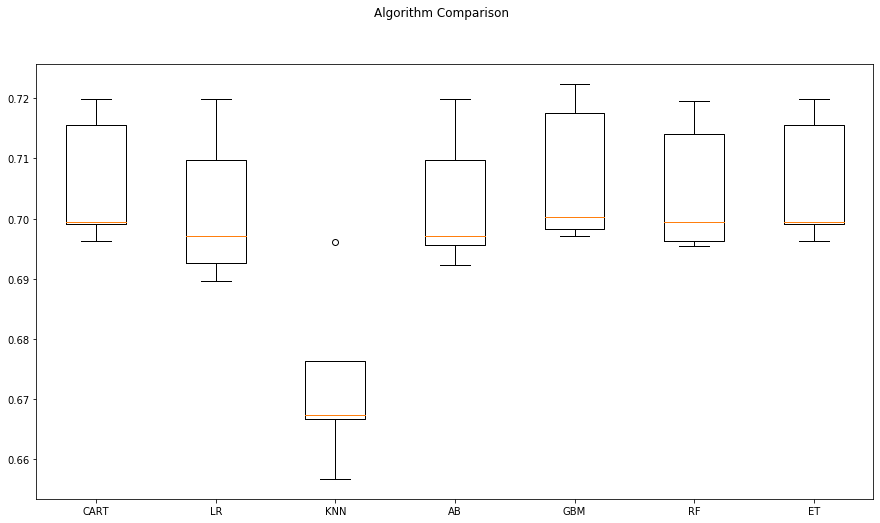

In [105]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

## Refinement

Let's use Grid Search to turn the hyperparameter to get the best hyperparameters to predict the test dataset

In [106]:
# Grid Search for CART model

param_dict = {
    'criterion':['gini','entropy'],
    'max_depth': range(1,20),
    'min_samples_split': range(2,10),
    'min_samples_leaf': range(1,5)
}

grid = GridSearchCV(DecisionTreeClassifier(), 
                    param_grid=param_dict, 
                    cv = 10,
                    verbose =1,n_jobs=-1)

grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 10 folds for each of 1216 candidates, totalling 12160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1586 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 4086 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 7586 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 12086 tasks      | elapsed:  2.1min


Best: 0.708171 using {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2}


[Parallel(n_jobs=-1)]: Done 12160 out of 12160 | elapsed:  2.1min finished


## Model evaluation and validation

In [107]:
grid_result.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [108]:
grid_result.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## Justification

In [109]:
grid_result.best_score_

0.7081709832683933

## Predict Test dataset

In [110]:
#: pick the best model
model = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=4, min_samples_split=2)
#: fit the model to the training data
model.fit(X_train, y_train)

#: make predictions on the test data
y_pred = model.predict(X_test)

#: Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.7002749770852429


## Feature Importance

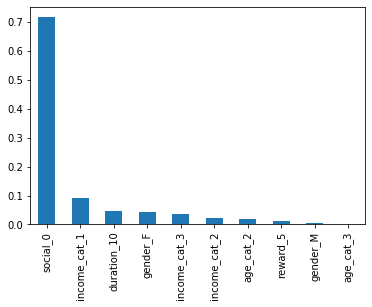

In [112]:
feature_importance = pd.Series(data=model.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False).head(10).plot(kind='bar')